In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [10]:
device = torch.device("mps" if torch.backends.mps.is_built() else "cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: mps


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # ResNet input size
        transforms.RandomHorizontalFlip(),  # Data augmentation
        transforms.RandomRotation(10),  # Data augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # Imagenet mean
                             [0.229, 0.224, 0.225])  # Imagenet std
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}


In [12]:
train_dataset = datasets.ImageFolder(root='/Users/chyavanshenoy/Desktop/UniProjectGithub/AAI-501-Final-Project/Training/dataset/ai_art_classification/train', transform=data_transforms['train'])
print(f"Classes: {train_dataset.classes}")

Classes: ['AI_GENERATED', 'NON_AI_GENERATED']


In [13]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [14]:
model = models.resnet50(pretrained=True)

# Freeze all layers if you want to use the model as a feature extractor
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Two classes: AI-generated and human-made

model = model.to(device)

/opt/anaconda3/envs/Torch-Test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/Torch-Test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
criterion = nn.CrossEntropyLoss()

# Only train the final layer parameters
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)


In [17]:
num_epochs = 15

for epoch in range(num_epochs):
    model.to(device)
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Store predictions and labels for metrics calculation
        preds = outputs.argmax(dim=1)  # Assuming classification task
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_dataset)

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, '
          f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, '
          f'Recall: {recall:.4f}, F1 Score: {f1:.4f}')

Epoch 1/15, Loss: 0.2544, Accuracy: 0.8957, Precision: 0.8957, Recall: 0.8957, F1 Score: 0.8955
Epoch 2/15, Loss: 0.2448, Accuracy: 0.8983, Precision: 0.8983, Recall: 0.8983, F1 Score: 0.8981
Epoch 3/15, Loss: 0.2439, Accuracy: 0.9006, Precision: 0.9006, Recall: 0.9006, F1 Score: 0.9004
Epoch 4/15, Loss: 0.2384, Accuracy: 0.9011, Precision: 0.9011, Recall: 0.9011, F1 Score: 0.9010
Epoch 5/15, Loss: 0.2325, Accuracy: 0.9042, Precision: 0.9043, Recall: 0.9042, F1 Score: 0.9041
Epoch 6/15, Loss: 0.2325, Accuracy: 0.9026, Precision: 0.9027, Recall: 0.9026, F1 Score: 0.9024
Epoch 7/15, Loss: 0.2277, Accuracy: 0.9047, Precision: 0.9047, Recall: 0.9047, F1 Score: 0.9046
Epoch 8/15, Loss: 0.2247, Accuracy: 0.9069, Precision: 0.9069, Recall: 0.9069, F1 Score: 0.9067
Epoch 9/15, Loss: 0.2278, Accuracy: 0.9064, Precision: 0.9064, Recall: 0.9064, F1 Score: 0.9063
Epoch 10/15, Loss: 0.2176, Accuracy: 0.9111, Precision: 0.9111, Recall: 0.9111, F1 Score: 0.9110
Epoch 11/15, Loss: 0.2190, Accuracy: 0.

In [26]:
# Display metrics as a table
import pandas as pd

metrics = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})

print(metrics)
metrics

   Accuracy  Precision    Recall  F1 Score
0  0.910087   0.910111  0.910087   0.90994


,Accuracy,Precision,Recall,F1 Score
0,0.910087,0.910111,0.910087,0.90994


In [41]:
torch.save(model.state_dict(), 'resnet50_finetuned.pth')


In [18]:
class_names = train_dataset.classes

In [22]:
%pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


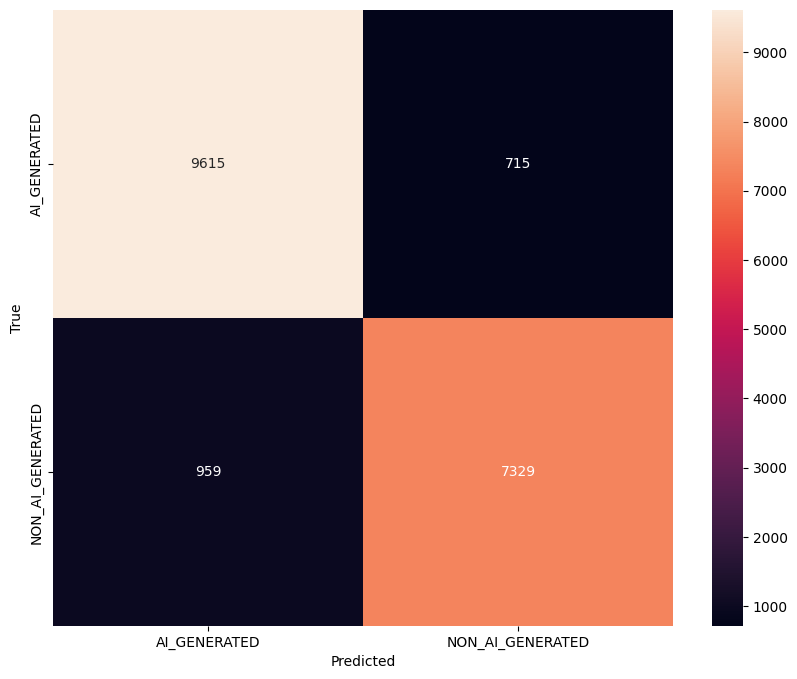

In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

# Infer

In [20]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

In [21]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [22]:
# model = models.resnet18()
model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

In [23]:
model.load_state_dict(torch.load('resnet50_finetuned.pth', map_location=device))
model = model.to(device)
model.eval()

/var/folders/d9/34q0n1js31x765w00t009x6c0000gn/T/ipykernel_18716/1475148921.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet50_fi

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [25]:
class_names = ['AI_GENERATED', 'NON_AI_GENERATED']

In [26]:
def process_image(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f'Error opening image {image_path}: {e}')
        return None
    image = data_transforms(image)
    image = image.unsqueeze(0)
    return image

def predict(image_path, model):
    image = process_image(image_path)
    if image is None:
        return None
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    return preds.item()

In [32]:
image_path = '/Users/chyavanshenoy/Desktop/UniProjectGithub/AAI-501-Final-Project/Training/MPS/Efficient net/Test/test/1.jpg'  # Replace with your image path
prediction = predict(image_path, model)
if prediction is not None:
    predicted_class = class_names[prediction]
    print(f'The model predicts that the image is: {predicted_class}')
else:
    print('Prediction could not be made.')

The model predicts that the image is: AI_GENERATED
